In [118]:
using DIVAnd
include("./MVREDIVAnd.jl")
using Dates
using PyPlot
using NCDatasets
const plt = PyPlot
using PyCall
mpl = pyimport("matplotlib")
mpl.style.use("./mosaic.mplstyle")
ccrs = pyimport("cartopy.crs")
cfeature = pyimport("cartopy.feature")
coast = cfeature.GSHHSFeature(scale="i")

PyObject <cartopy.feature.GSHHSFeature object at 0x7f00f8da1c60>

## Files and directories

In [124]:
datadir = "../data/"
figdir = "../figures"
isdir(figdir) ? @debug("Already created") : mkpath(figdir)
datafile = joinpath(datadir, "Ocean_Basic_Hydrographic_Observations_from_Polarstern_and_Ocean_City_CTD_Profile_Data_uPlGpFAw.txt")
datafilenc = joinpath(datadir, "data_from_Ocean_Basic_Hydrographic_Observations_from_Polarstern_and_Ocean_City_CTD_Profile_Data_uPlGpFAw.nc")
isfile(datafile) & isfile(datafilenc)

true

In [120]:
longname = "in-situ temperature ITS-90"

"in-situ temperature ITS-90"

## Read data

In [121]:
lon, lat, pressure, time, var, varunits = MVREDIVAnd.read_data_nc(datafilenc, longname);

### Vectorise

In [108]:
lonall, latall, pressureall, timeall, varall = MVREDIVAnd.vectorise_data(lon, lat, pressure, time, var);

## Plots
### Setting the projections

In [109]:
proj1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
proj2 = ccrs.NorthPolarStereo()
proj3 = ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=90.0)

PyObject <Projected CRS: +proj=nsper +a=6378137.0 +lon_0=0.0 +lat_0=90.0 +h ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Vertical Perspective
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

### Observation locations

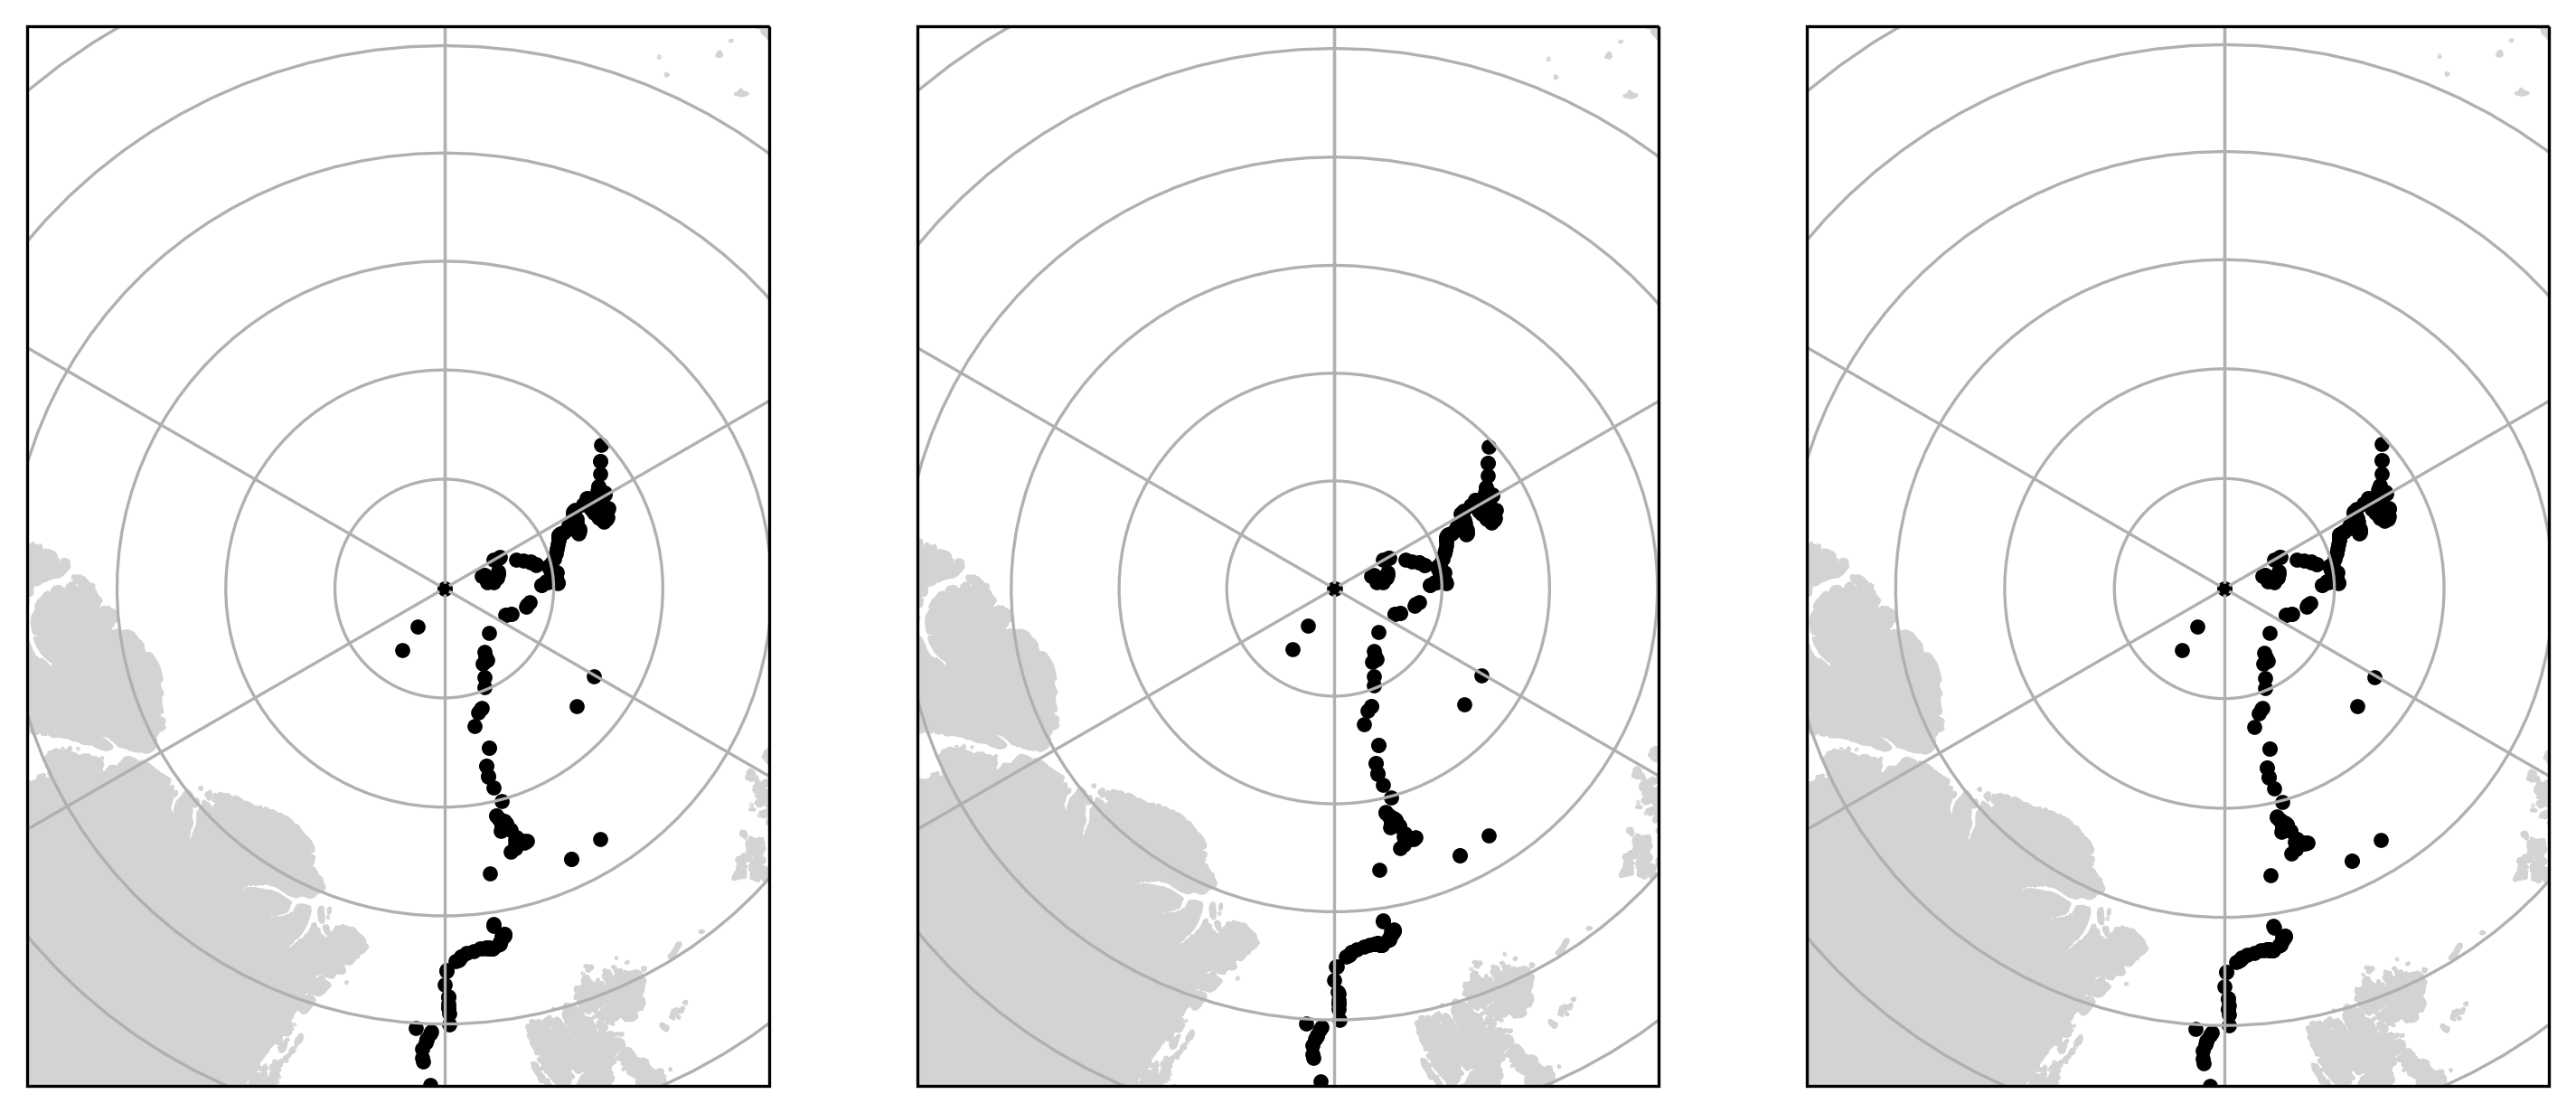

PyObject <cartopy.mpl.gridliner.Gridliner object at 0x7f00f683aa40>

In [67]:
fig = plt.figure()
ax = plt.subplot(131, projection=proj1)
ax.plot(lon, lat, transform=ccrs.PlateCarree(), "ko", ms=3)
ax.set_extent([-40, 150, 75, 90.]) 
ax.add_feature(coast, color="lightgray")
ax.gridlines()

ax = plt.subplot(132, projection=proj2)
ax.plot(lon, lat, transform=ccrs.PlateCarree(), "ko", ms=3)
ax.set_extent([-40, 150, 75, 90.]) 
ax.add_feature(coast, color="lightgray")
ax.gridlines()

ax = plt.subplot(133, projection=proj3)
ax.plot(lon, lat, transform=ccrs.PlateCarree(), "ko", ms=3)
ax.set_extent([-40, 150, 75, 90.]) 
ax.add_feature(coast, color="lightgray")
ax.gridlines()

### All the profiles together

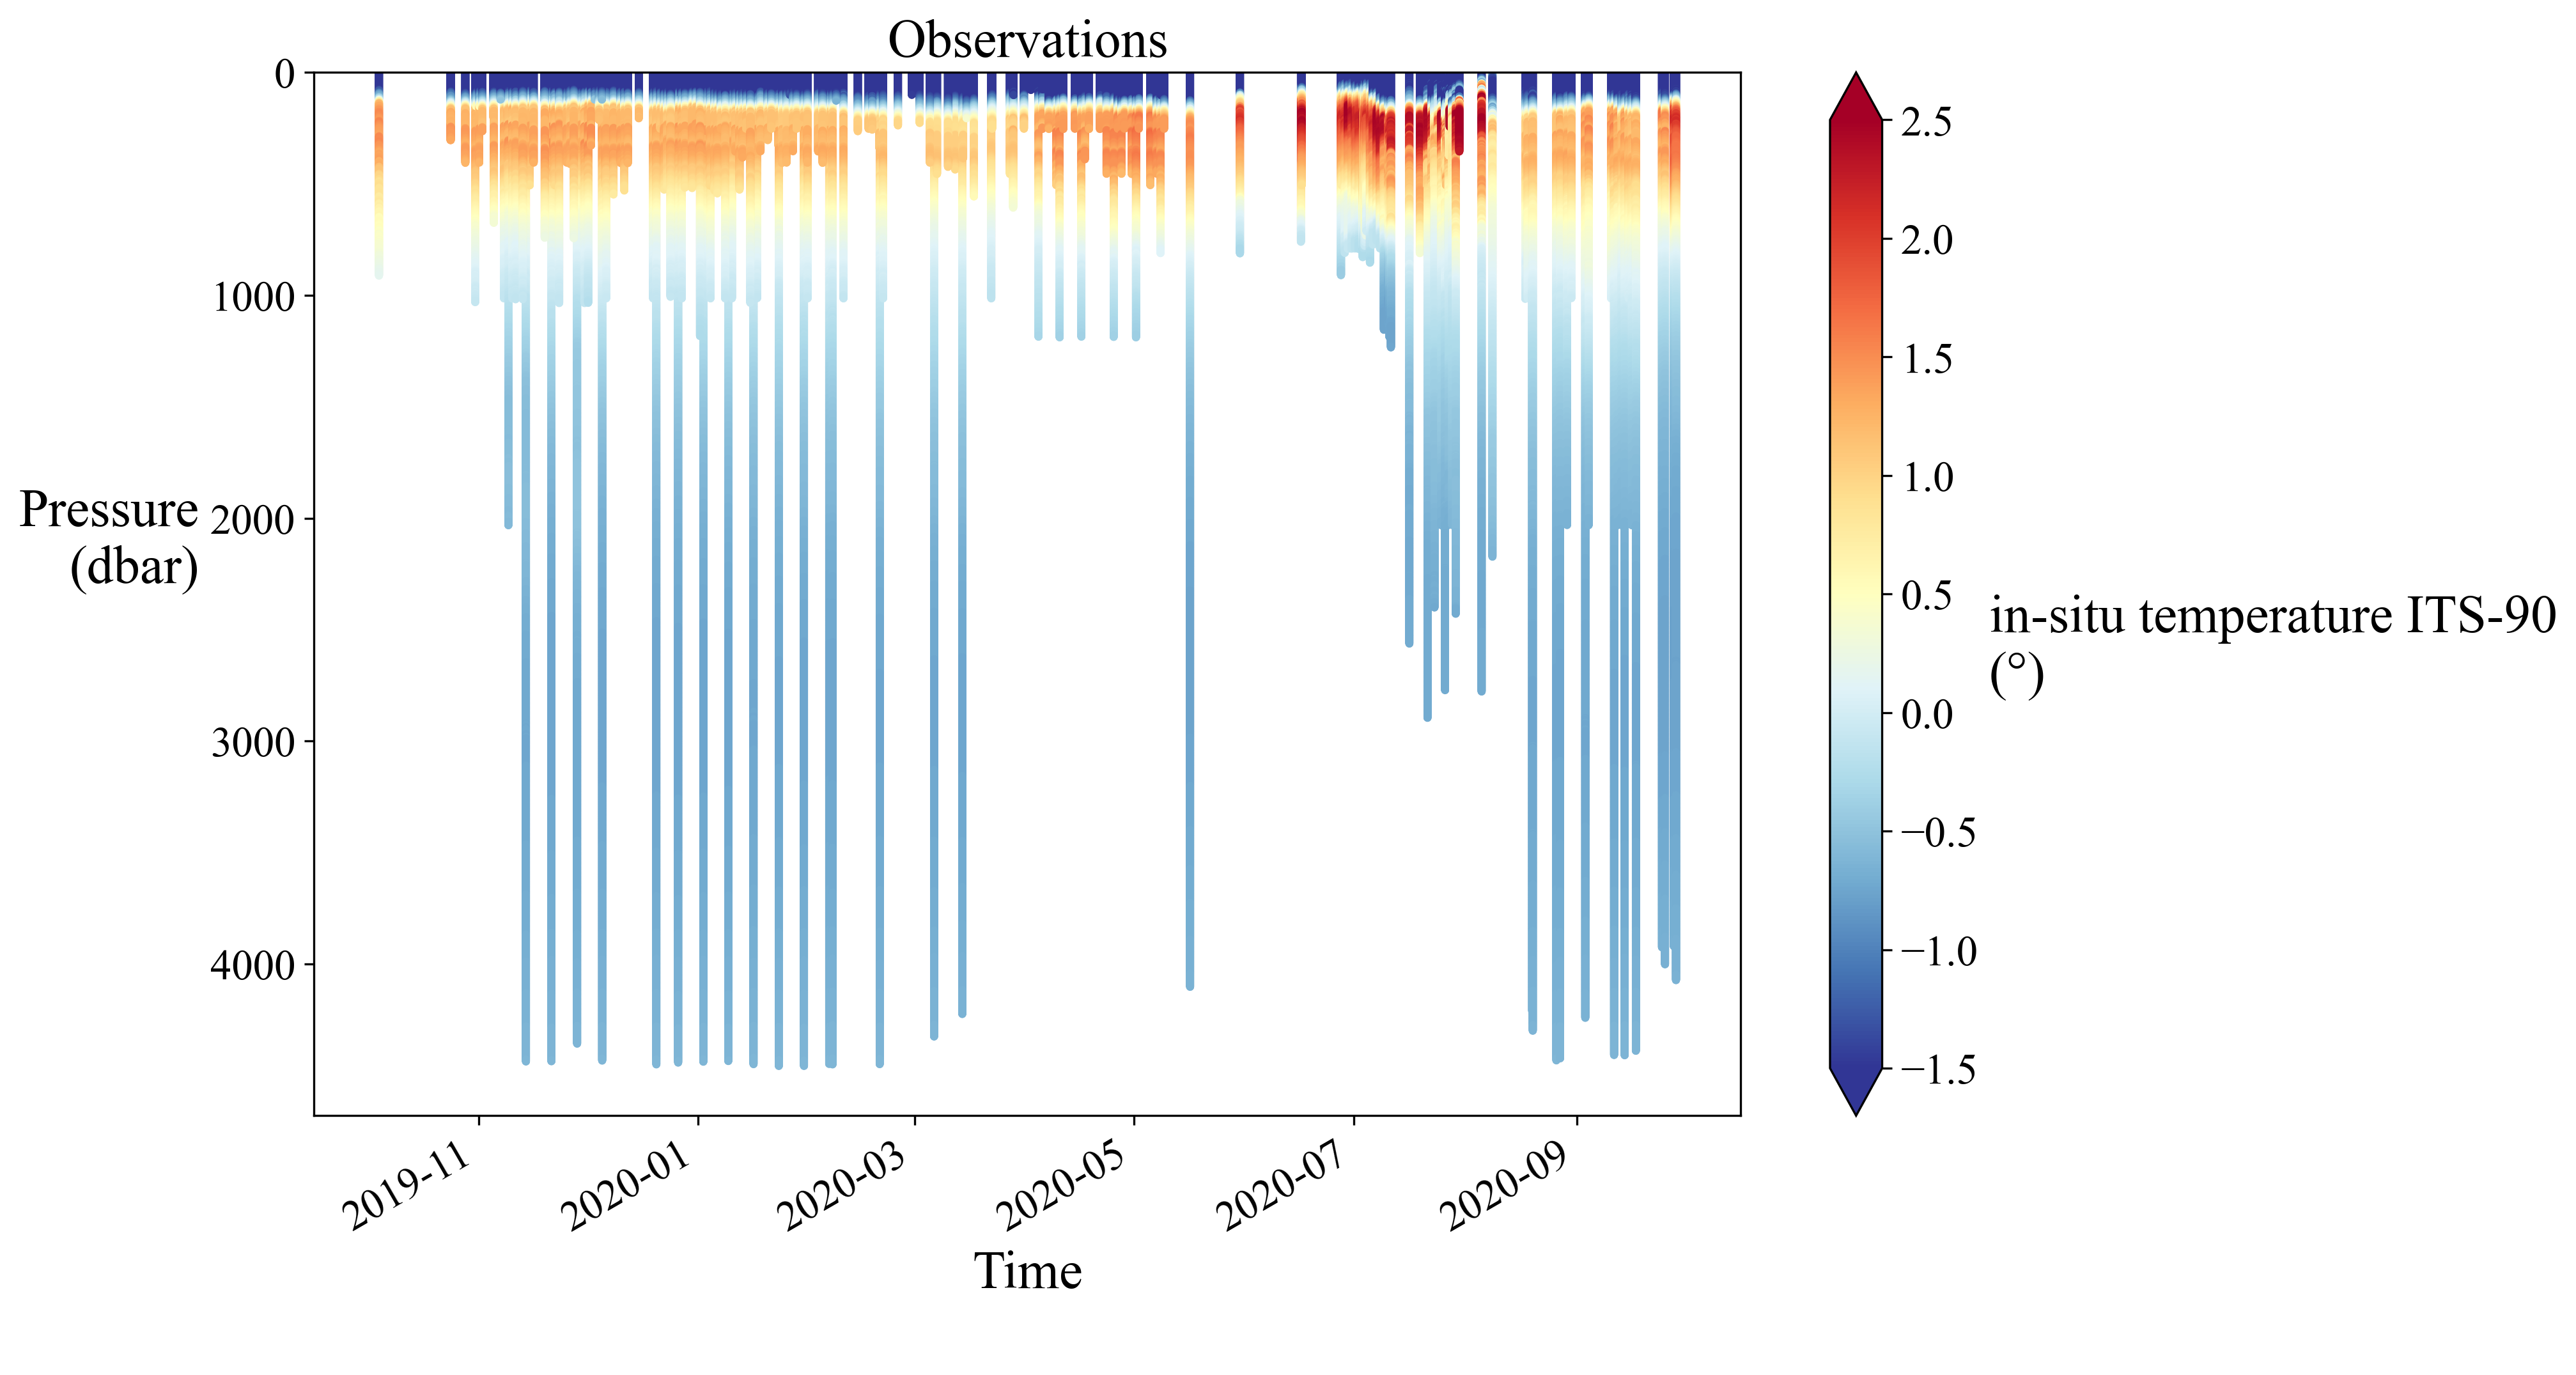

In [149]:
fig = plt.figure()
ax = plt.subplot(111)
scat = ax.scatter(timeall, pressureall, s=4, c=varall, cmap=plt.cm.RdYlBu_r, 
vmin=-1.5, vmax=2.5)
cb = plt.colorbar(scat, extend="both")
cb.set_label("$(longname)\n($(varunits))", rotation=0, ha="left")
ax.set_ylim(0, )
ax.set_xlabel("Time\n")
ax.set_ylabel("Pressure\n(dbar)", rotation=0, ha="right")
ax.set_title("Observations")
plt.gca().invert_yaxis()
fig.autofmt_xdate()
plt.savefig(joinpath(figdir, replace(longname, " "=>"_") * "_observations"))

## Analysis
### Set grid

In [95]:
daystart = Dates.datetime2julian(DateTime(2019, 10, 4))
dayend = Dates.datetime2julian(DateTime(2020, 09, 28))
daygrid = daystart:1:dayend
depthgrid = 0:10:4500
ddd = collect(DateTime(2019, 10, 4):Dates.Day(1):DateTime(2020, 09, 28));
mask_rect, pmn, xyi = DIVAnd_rectdom(daygrid, depthgrid);

451

### Set analysis parameters

In [98]:
len = (5. .* ones(length(daygrid), length(depthgrid)),  # days
       10.0 .* ones(length(daygrid), length(depthgrid))) # 
epsilon2 = 10.

10.0

### Perform interpolation

In [100]:
@time var_interp, var_struct = DIVAndrun(mask_rect, pmn, xyi, (datesnum, pressureall), 
varall, len, epsilon2, alphabc=0);

 11.857904 seconds (21.65 M allocations: 3.468 GiB, 4.97% gc time, 90.17% compilation time)


### Make plot

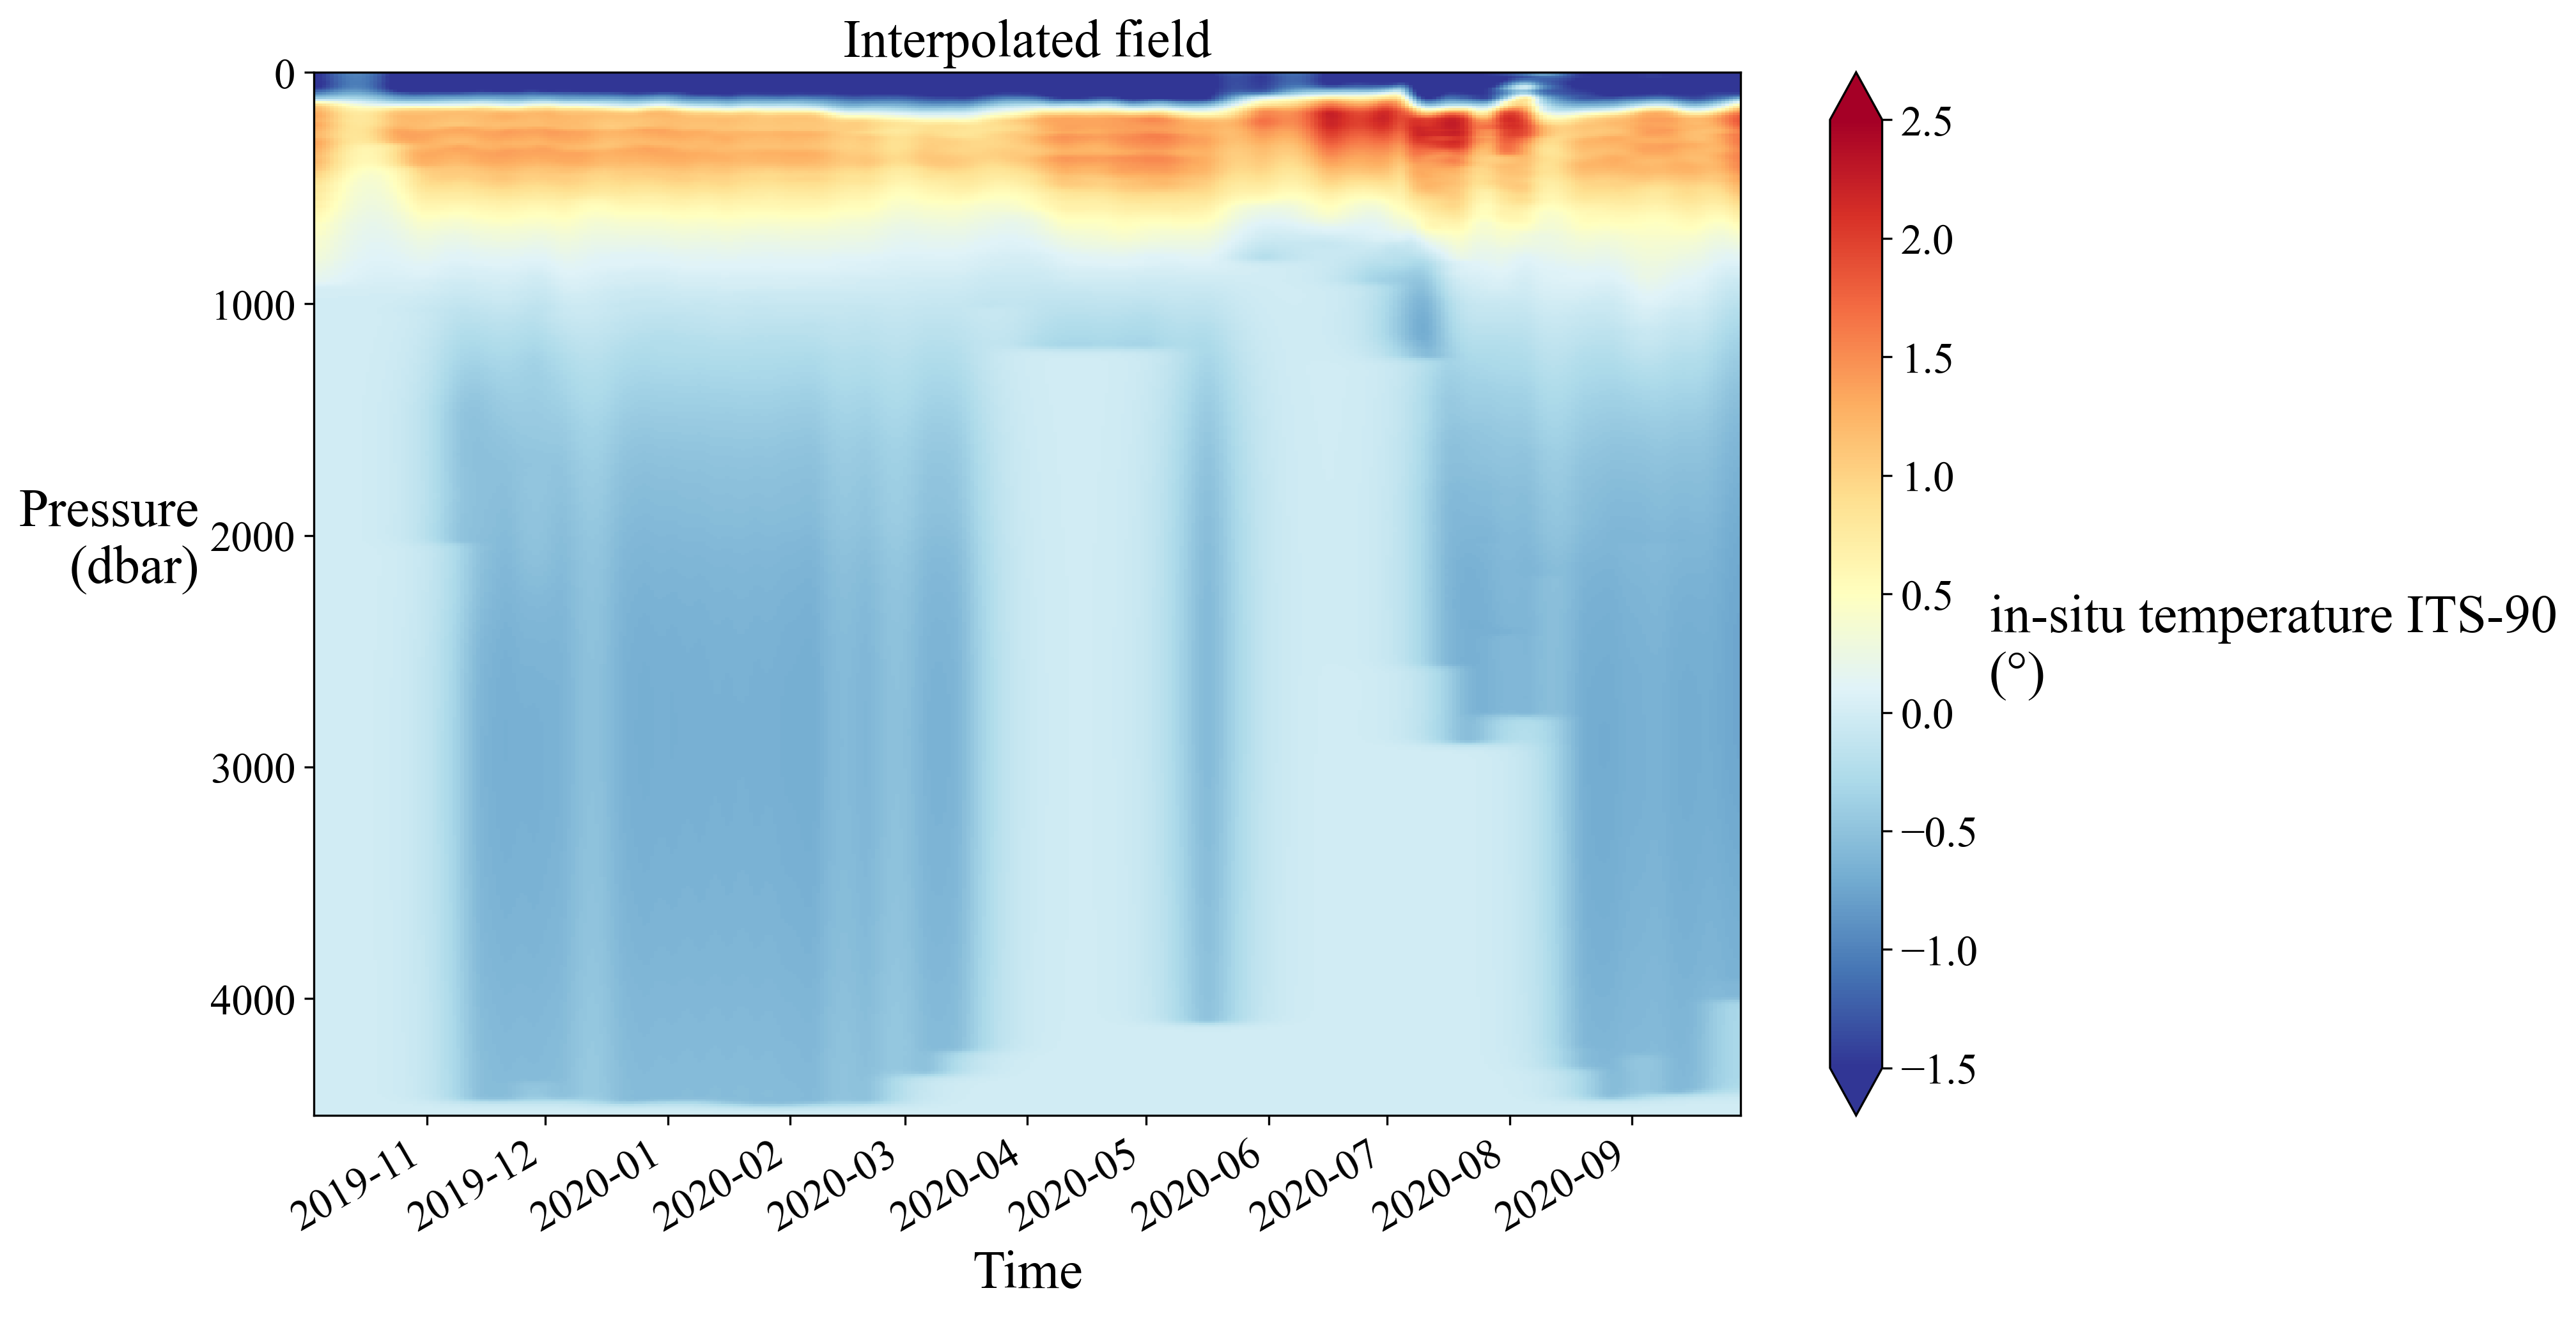

In [151]:
fig = plt.figure()
ax = plt.subplot(111)
pcm = ax.pcolormesh(ddd, depthgrid, var_interp', cmap=plt.cm.RdYlBu_r, vmin=-1.5, vmax=2.5)
cb = plt.colorbar(pcm, extend="both")
cb.set_label("$(longname)\n($(varunits))", rotation=0, ha="left")
ax.set_ylim(0, )
ax.set_xlabel("Time")
ax.set_ylabel("Pressure\n(dbar)", rotation=0, ha="right")
ax.set_title("Interpolated field")
plt.gca().invert_yaxis()
fig.autofmt_xdate()
plt.savefig(joinpath(figdir, replace(longname, " "=>"_") * "_interpfield"))